# 🚗 Car price prediction 
 
**Author:** José Antônio Afonso   
**Country:** Angola 


---

<h1>Import libraries</h1>

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de Regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Métricas de Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuração
plt.style.use('seaborn-v0_8')
%matplotlib inline

<h1>Load and exploring the data</h1>

In [3]:
# Carregar dataset (ajusta o nome do ficheiro)
# Supondo 'car_data.csv' ou similar
df = pd.read_csv('../data/car data.csv')

# Exploração inicial
print("=== Initial exploration of the data ===")
print(f"Dataset form: {df.shape}")
print(f"\nFirst 5  rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nDescriptive statistics:")
print(df.describe())

print(f"\nNull values per column:")
print(df.isnull().sum())

# Verificar a coluna de preço (target)
print(f"\nAvailable columns: {df.columns.tolist()}")

=== Initial exploration of the data ===
Dataset form: (301, 9)

First 5  rows:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year      

<h1>Exploratory data analysis (EDA)</h1>

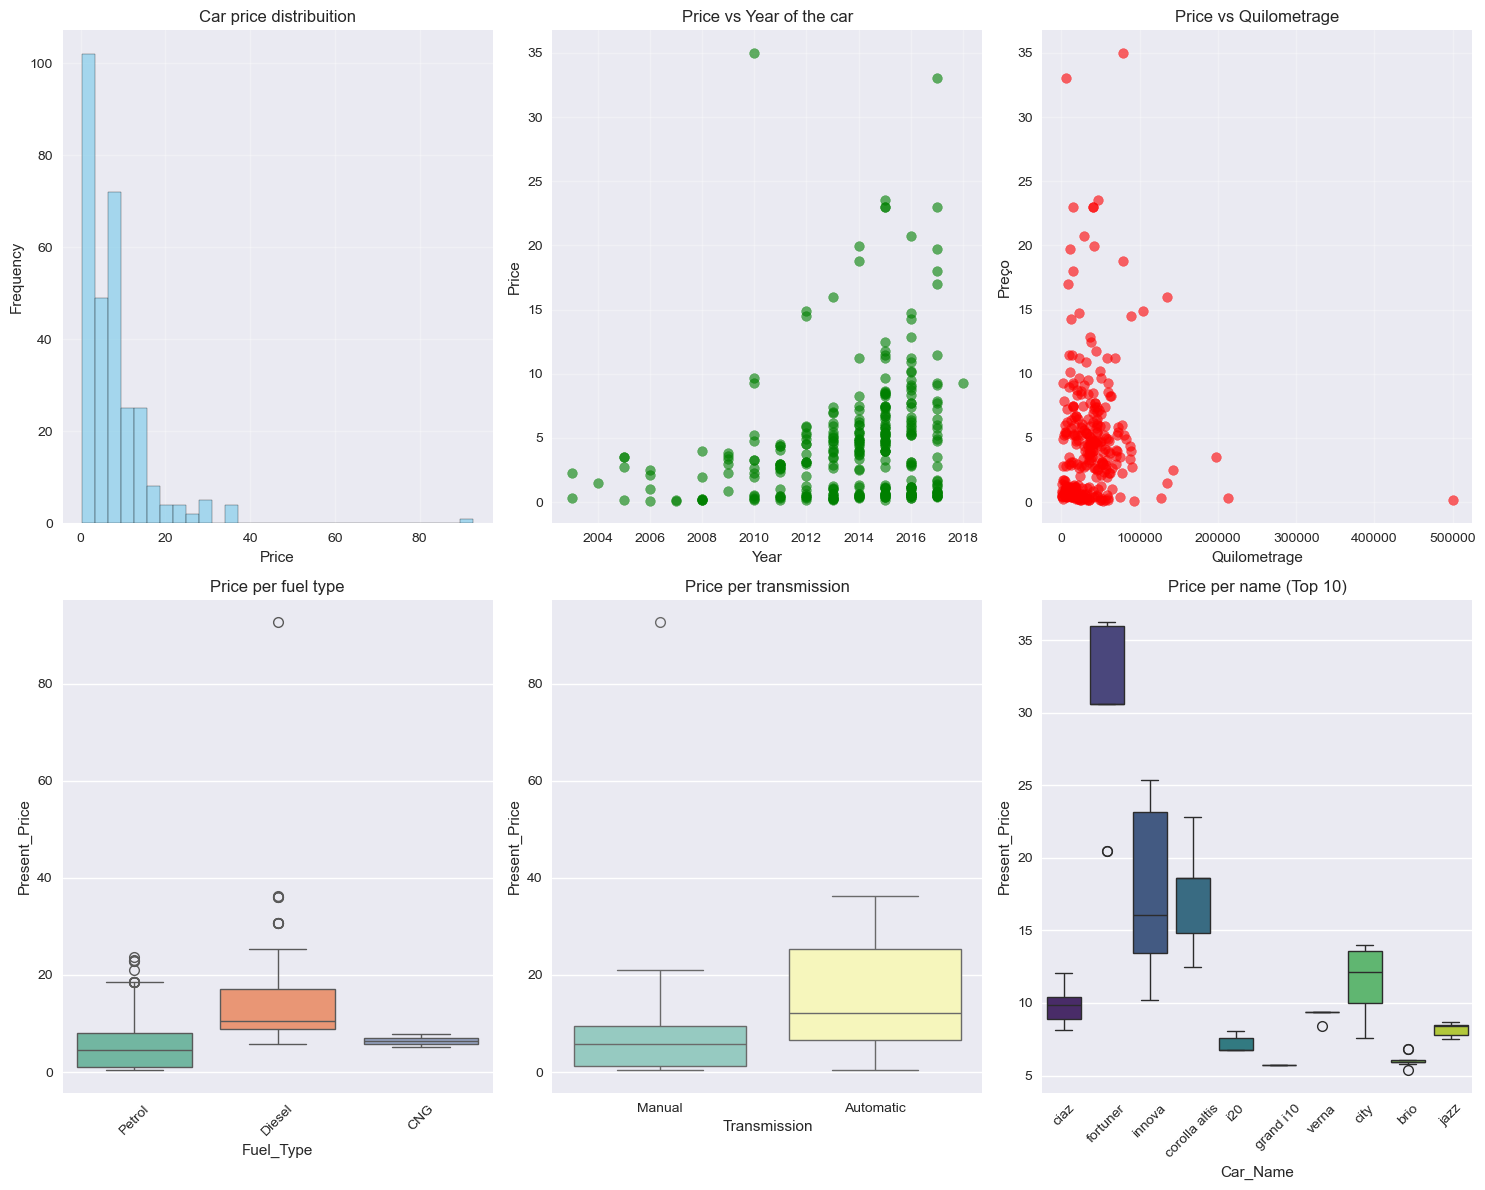

In [4]:
# Configuração para visualizações
plt.figure(figsize=(15, 12))

# 1. Distribuição do preço (target)
plt.subplot(2, 3, 1)
plt.hist(df['Present_Price'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Car price distribuition')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Preço vs Ano
plt.subplot(2, 3, 2)
plt.scatter(df['Year'], df['Present_Price'], alpha=0.6, color='green')
plt.title('Price vs Year of the car')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)

# 3. Preço vs Quilometragem
plt.subplot(2, 3, 3)
plt.scatter(df['Driven_kms'], df['Present_Price'], alpha=0.6, color='red')
plt.title('Price vs Quilometrage')
plt.xlabel('Quilometrage')
plt.ylabel('Preço')
plt.grid(True, alpha=0.3)

# 4. Preço por Tipo de Combustível
plt.subplot(2, 3, 4)
if 'Fuel_Type' in df.columns:
    sns.boxplot(data=df, x='Fuel_Type', y='Present_Price', palette='Set2')
    plt.title('Price per fuel type')
    plt.xticks(rotation=45)

# 5. Preço por Transmissão
plt.subplot(2, 3, 5)
if 'Transmission' in df.columns:
    sns.boxplot(data=df, x='Transmission', y='Present_Price', palette='Set3')
    plt.title('Price per transmission')

# 6. Preço por Marca (top 10)
plt.subplot(2, 3, 6)
if 'Car_Name' in df.columns or 'company' in df.columns:
    brand_col = 'Car_Name' if 'Car_Name' in df.columns else 'company'
    top_brands = df[brand_col].value_counts().head(10).index
    top_brands_data = df[df[brand_col].isin(top_brands)]
    sns.boxplot(data=top_brands_data, x=brand_col, y='Present_Price', palette='viridis')
    plt.title('Price per name (Top 10)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<h1>Correlation analysis</h1>

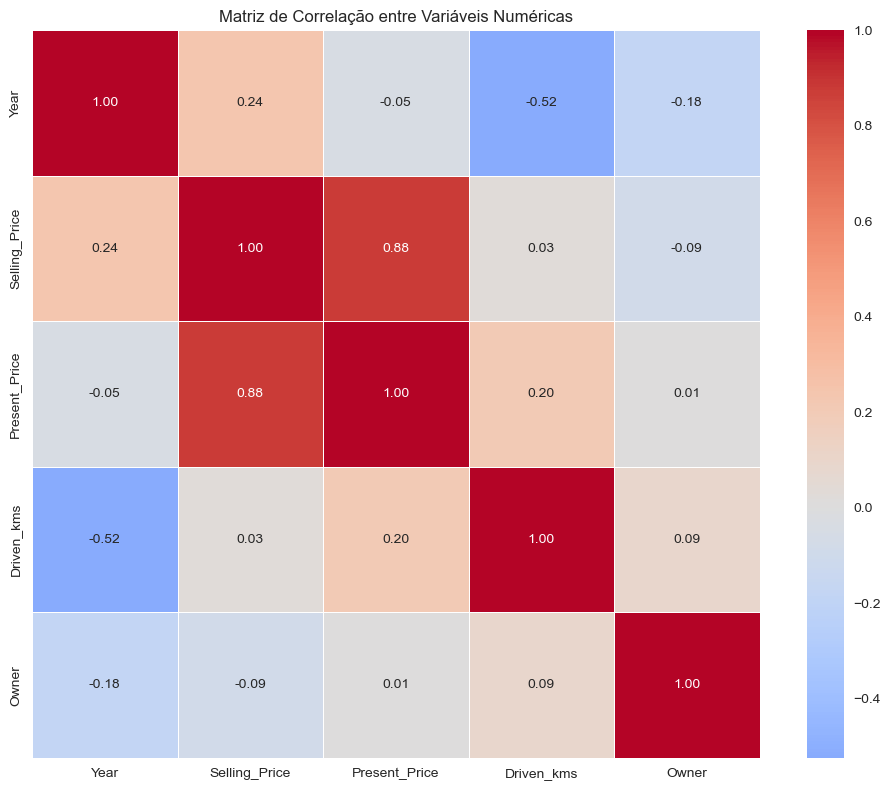

Correlation with price:
Selling_Price    1.000000
Present_Price    0.878914
Year             0.236141
Driven_kms       0.029187
Owner           -0.088344
Name: Selling_Price, dtype: float64


In [5]:
# Matriz de correlação para variáveis numéricas
plt.figure(figsize=(10, 8))

# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, fmt='.2f')
    plt.title('Matriz de Correlação entre Variáveis Numéricas')
    plt.tight_layout()
    plt.show()
    
    # Correlação com preço
    if 'Selling_Price' in correlation_matrix.columns:
        print("Correlation with price:")
        price_corr = correlation_matrix['Selling_Price'].sort_values(ascending=False)
        print(price_corr)

<h1>Pre-processing and Feature Engineering</h1>

In [7]:
# Identificar tipos de colunas
def prepare_features(df):
    # Fazer cópia para não modificar original
    df_clean = df.copy()
    
    # 1. Lidar com valores nulos
    print("Null values before the processing:")
    print(df_clean.isnull().sum())
    
    # Preencher numéricos com mediana, categóricos com moda
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['int64', 'float64']:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 2. Separar features e target
    X = df_clean.drop('Selling_Price', axis=1)  # Todas as colunas exceto preço
    y = df_clean['Selling_Price']  # Target
    
    return X, y

X, y = prepare_features(df)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nColunas em X: {X.columns.tolist()}")

Null values before the processing:
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64
Features shape: (301, 8)
Target shape: (301,)

Colunas em X: ['Car_Name', 'Year', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']


<h1>Preparing the data for the models</h1>

In [9]:
# Identificar colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Criar pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Numerical features: ['Year', 'Present_Price', 'Driven_kms', 'Owner']
Categorical features: ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']
Train: 240 samples
Test: 61 samples


<h1>Treinar Múltiplos Modelos</h1>

In [10]:
# Definir modelos a testar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf')
}

# Treinar e avaliar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Criar pipeline com pré-processamento + modelo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Treinar modelo
    pipeline.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = pipeline.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar resultados
    results[name] = {
        'model': pipeline,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Training Linear Regression...
Linear Regression - MAE: 2.04, RMSE: 3.04, R²: 0.5997

Training Ridge Regression...
Ridge Regression - MAE: 1.08, RMSE: 1.60, R²: 0.8893

Training Lasso Regression...
Lasso Regression - MAE: 1.98, RMSE: 2.75, R²: 0.6724

Training Random Forest...
Random Forest - MAE: 0.60, RMSE: 0.89, R²: 0.9659

Training Gradient Boosting...
Gradient Boosting - MAE: 0.58, RMSE: 0.97, R²: 0.9595

Training Support Vector Regression...
Support Vector Regression - MAE: 0.91, RMSE: 2.05, R²: 0.8182


<h1>Model evaluation and comparison</h1>


Comparing the model (ordered by RMSE)
                       Model       MAE      RMSE        R²
3              Random Forest  0.604621  0.885982  0.965924
4          Gradient Boosting  0.581497  0.966088  0.959483
1           Ridge Regression  1.082001  1.597132  0.889266
5  Support Vector Regression  0.914191  2.046438  0.818198
2           Lasso Regression  1.984125  2.746913  0.672440
0          Linear Regression  2.036517  3.036626  0.599702


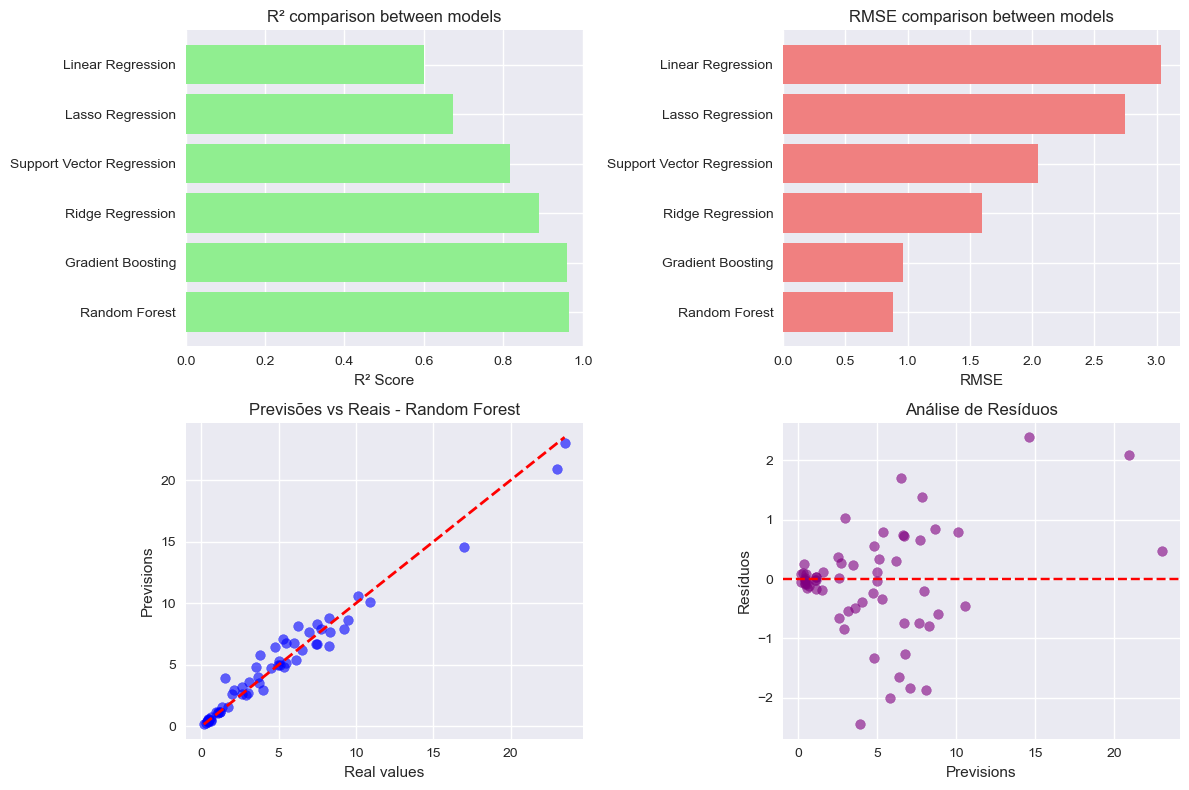

In [11]:
# Comparar performance dos modelos
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[name]['mae'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()],
    'R²': [results[name]['r2'] for name in results.keys()]
}).sort_values('RMSE')

print("\n" + "="*60)
print("Comparing the model (ordered by RMSE)")
print("="*60)
print(comparison_df)

# Visualização da comparação
plt.figure(figsize=(12, 8))

# Subplot 1: Comparação de R²
plt.subplot(2, 2, 1)
plt.barh(comparison_df['Model'], comparison_df['R²'], color='lightgreen')
plt.title('R² comparison between models')
plt.xlabel('R² Score')
plt.xlim(0, 1)

# Subplot 2: Comparação de RMSE
plt.subplot(2, 2, 2)
plt.barh(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.title('RMSE comparison between models')
plt.xlabel('RMSE')

# Subplot 3: Previsões vs Valores Reais (melhor modelo)
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Previsions')
plt.title(f'Previsões vs Reais - {best_model_name}')

# Subplot 4: Resíduos
plt.subplot(2, 2, 4)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsions')
plt.ylabel('Resíduos')
plt.title('Análise de Resíduos')

plt.tight_layout()
plt.show()

<h1>Feature Importance (for tree-based models)</h1>

In [12]:
# Função para fazer previsões em novos carros
def predict_car_price(model, car_features):
    """
    Predict the price of a car based on the features
    """
    # Criar DataFrame com as features
    new_car_df = pd.DataFrame([car_features])
    
    # Fazer previsão
    predicted_price = model.predict(new_car_df)[0]
    
    return predicted_price

# Exemplo de uso com o melhor modelo
if 'best_model_name' in locals():
    # Exemplo de características de um carro
    example_car = {
        'Year': 2020,
        'Driven_kms': 15000,
        'fuel_type': 'Petrol',
        'Transmission': 'Manual',
        'Car_Name': 'Toyota',
        'Present_Price':20.9,
        'Selling_type':'Deal',
        'Transmission':'Manual',
        'Owner':0,
        'Fuel_Type':'Diesel'
        # Adiciona mais características conforme teu dataset
    }
    
    predicted_price = predict_car_price(best_model, example_car)
    print(f"\nPrevision example:")
    print(f"Feature: {example_car}")
    print(f"Predicted price: €{predicted_price:,.2f}")


Prevision example:
Feature: {'Year': 2020, 'Driven_kms': 15000, 'fuel_type': 'Petrol', 'Transmission': 'Manual', 'Car_Name': 'Toyota', 'Present_Price': 20.9, 'Selling_type': 'Deal', 'Owner': 0, 'Fuel_Type': 'Diesel'}
Predicted price: €14.82


<h1> Conclusions and Insights</h1>

In [31]:
print("="*70)
print("RELATÓRIO FINAL - PREVISÃO DE PREÇOS DE CARROS")
print("="*70)

print(f"📊 PERFORMANCE DO MELHOR MODELO ({best_model_name}):")
print(f"   • R² Score: {results[best_model_name]['r2']:.4f}")
print(f"   • MAE: €{results[best_model_name]['mae']:,.2f}")
print(f"   • RMSE: €{results[best_model_name]['rmse']:,.2f}")

print(f"\n🔍 INSIGHTS DO MODELO:")
print(f"   • Total de features utilizadas: {len(X.columns)}")
print(f"   • Features numéricas: {len(numeric_features)}")
print(f"   • Features categóricas: {len(categorical_features)}")

print(f"\n💡 INTERPRETAÇÃO DO R² SCORE:")
r2_score_value = results[best_model_name]['r2']
if r2_score_value > 0.8:
    print("   • Excelente! O modelo explica mais de 80% da variabilidade dos preços")
elif r2_score_value > 0.6:
    print("   • Bom! O modelo explica mais de 60% da variabilidade dos preços")
else:
    print("   • Pode ser melhorado. Considera feature engineering adicional")

print(f"\n🚗 FATORES QUE MAIS INFLUENCIAM O PREÇO:")
if 'feature_importance_df' in locals():
    top_factors = feature_importance_df.head(3)['feature'].tolist()
    for i, factor in enumerate(top_factors, 1):
        print(f"   {i}. {factor}")

RELATÓRIO FINAL - PREVISÃO DE PREÇOS DE CARROS
📊 PERFORMANCE DO MELHOR MODELO (Random Forest):
   • R² Score: 0.9659
   • MAE: €0.60
   • RMSE: €0.89

🔍 INSIGHTS DO MODELO:
   • Total de features utilizadas: 8
   • Features numéricas: 4
   • Features categóricas: 4

💡 INTERPRETAÇÃO DO R² SCORE:
   • Excelente! O modelo explica mais de 80% da variabilidade dos preços

🚗 FATORES QUE MAIS INFLUENCIAM O PREÇO:
